# Problem Statement
We will investigate how TimeGAN can help us understand the distributions of future time-series when it comes to PM2.5 time-series generation. We will answer questions such as, how worse can air quality be in a certain time frame? We will also look at how well TimeGAN can generate a PM2.5 time-series. TimeGAN was developed by Yoon et al, which you can take a detailed look at the architecture at https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

In [11]:
# Necessary Packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# TimeGAN model
from timegan import timegan
# Data Loading
from data_loading import real_data_loading
# Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

# Image display
from IPython.display import Image

import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data
We will be using Beijing datasets from 2010 to 2014 where we are interested in mean daily PM2.5 and AQI

In [ ]:
# data_path = "data/"
# data = [pd.read_csv(data_path + file) for file in os.listdir(data_path)]
# master_napa = pd.concat(data).reset_index()

In [ ]:
# # obtain only dail AQI and mean daily PM2.5 columns
# pm_data = master_napa[["Date", "Daily Mean PM2.5 Concentration", "DAILY_AQI_VALUE"]]
# pm_data.to_csv("data/napa_master_date.csv", index=False)

In [ ]:
# beijing_data = pd.read_csv("data/beijing.csv")
# beijing_master = beijing_data.drop(columns=["No", "cbwd"])
# beijing_master.to_csv("data/beijing_master.csv", index=False)

In [32]:
# use TimeGAN's data loading 
data_name = 'beijing'
sequence_length = 24
ori_data = real_data_loading(data_name, sequence_length)
beijing_data = pd.read_csv("data/beijing_master.csv")

# Network Parameters
The following parameters will be experimentally evaluated 
* module: gru, lstm, or lstmLN
* hidden_dim: hidden dimensions
* num_layer: number of layers
* iteration: number of training iterations
* batch_size: the number of samples in each batch

# TimeGAN Evaluation
Now that TimeGAN has generated data, we want to evaluate it's performance based on three metrics: discriminative score, predictive score, and visualization techniques

In [4]:
metrics = np.load("./results/timegan_data/metrics.npy", allow_pickle=True)

### 1.  Discriminative Score
As per Yoon et al, "to evaluate the classification accuracy between original and synthetic data using post-hoc RNN network", we label original data sequences as "real" and generated sequences as "fake" and we train and test an off-the-shelf RNN classifier and report the classification error on the test set.

In [8]:
metrics.item()["discriminative"]

0.11072241523900803

### 2. Predictive Score
Now we will use a post-hoc RNN to predict one step ahead in the time-series evaluate the performance of the prediction in terms of MAE.

In [9]:
metrics.item()["predictive"]

0.3929747073139479

### 3. Visualization of Data
We will use PCA and t-SNE to visualize the data

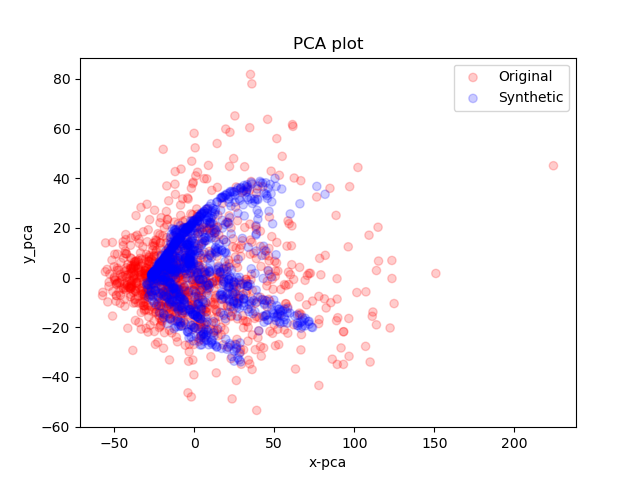

In [13]:
Image(filename="results/timegan_data/figures/pca.png")

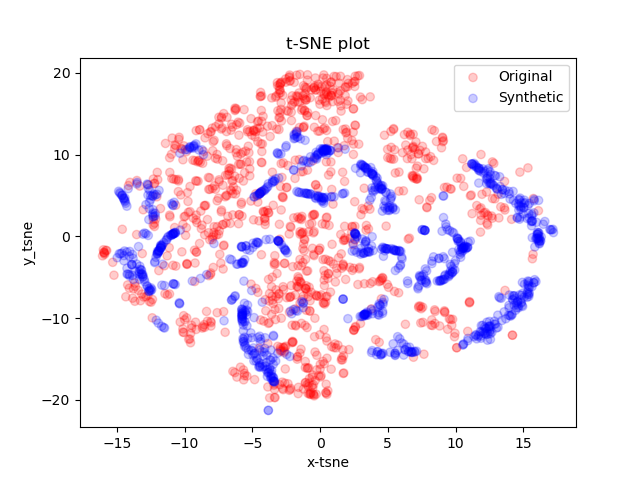

In [14]:
Image(filename="results/timegan_data/figures/tsne.png")

# Stitch generated sequences
We will now stitch the generated sequences 

In [45]:
def stitch_generations(gen_location, original_data, ori_data, seq_len):
    original_num_rows = original_data.shape[0]
    num_gammas = original_num_rows // seq_len # number of chunks of seq_len rows in the generation
    num_remaining_rows = original_num_rows - seq_len*num_gammas
    stitch = np.concatenate([np.load(gen_location + "generated_data_{}.npy".format(i*seq_len)) for i in range(num_gammas)])
    last_gamma = np.load(gen_location + "generated_data_{}.npy".format(len(ori_data) - 1))
    remaining_rows = last_gamma[-num_remaining_rows:]
    stitch = np.concatenate((stitch, remaining_rows))
    
    assert stitch.shape[0] == original_data.shape[0]
    return stitch

In [48]:
stitched_generation = stitch_generations("results/timegan_data/generated/", beijing_data, ori_data, sequence_length)
np.save("results/timegan_data/generation_master.npy", stitched_generation)